# Metabolomics Data Analysis for Cardiotoxicity Prediction

This Jupyter Notebook builds machine learning models (Logistic Regression and Random Forest) to predict cardiotoxicity using a targeted metabolomics dataset from human induced pluripotent stem cell-derived cardiomyocytes (hiPSC-CMs). The goal is to identify biomarkers of cardiotoxicity by predicting the `Effect` column (Cardiotoxic vs. Non) using metabolite intensities (e.g., Arachidonic Acid, Lactate).

## Objectives
- Load and preprocess the dataset.
- Train and compare Logistic Regression and Random Forest models.
- Evaluate model performance with confusion matrices, ROC curves, and F1-score.
- Identify key metabolites (biomarkers) using model coefficients and feature importance.

## Prerequisites
- R packages: `tidyverse`, `caret`, `randomForest`, `pROC`, `ggplot2`, `glmnet`, `DMwR`.
- Dataset: `A_Targeted_Metabolomics-Based_Assay_Using_Human_Induced_Pluripotent_Stem_Cell-Derived_Cardiomyocytes_rawdata.csv`.


In [1]:
# install.packages(c("tidyverse", "caret", "randomForest", "pROC", "ggplot2", "glmnet", "DMwR"))

# Load packages
library(tidyverse)
library(caret)
library(randomForest)
library(pROC)
library(ggplot2)
library(glmnet)
library(DMwR)

print("Packages loaded successfully.")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are 

[1] "Packages loaded successfully."


## Step 1: Load and Prepare the Data

We load the dataset and transform it from long format (one row per metabolite per sample) to wide format (one row per sample, columns for metabolite intensities). We also log-transform, handle outliers, and scale the intensities to prepare for modeling.

**Dataset Columns**:
- `Compound`: e.g., Phenylphenol, Fluorouracil.
- `Effect`: Cardiotoxic or Non (our label).
- `Metabolite`: e.g., Arachidonic Acid, Lactate.
- `Dose`: Concentration (μM).
- `SampleType`: Cells or Media.
- `Well`: Plate well identifier.
- `ApexIntensity`: Metabolite intensity.

Replace the file path with your dataset’s location.

In [2]:
# Load the dataset
data <- read.csv("/home/ilesh-dhall/Metabolomics-Biomarker-Discovery/data/A_Targeted_Metabolomics-Based_Assay_Using_Human_Induced_Pluripotent_Stem_Cell-Derived_Cardiomyocytes_rawdata.csv")

# Pivot to wide format
data_wide <- data %>%
  mutate(sample_id = paste(Compound, Dose, SampleType, Well, sep = "_")) %>%
  pivot_wider(
    id_cols = c(sample_id, Effect, Compound, Dose, SampleType, Well),
    names_from = Metabolite,
    values_from = ApexIntensity,
    values_fn = mean  # If duplicates, take mean
  ) %>%
  drop_na()

# Select features and label
features <- data_wide %>%
  select(-sample_id, -Effect, -Compound, -Dose, -SampleType, -Well) %>%
  mutate_all(~log2(. + 1))  # Log-transform

# Handle outliers: Cap at 1st and 99th percentiles
features <- features %>%
  mutate_all(~ifelse(. > quantile(., 0.99), quantile(., 0.99), ifelse(. < quantile(., 0.01), quantile(., 0.01), .)))

# Remove highly correlated features
cor_matrix <- cor(features)
high_cor <- findCorrelation(cor_matrix, cutoff = 0.8)
if (length(high_cor) > 0) {
  features <- features[, -high_cor]
}

labels <- factor(data_wide$Effect, levels = c("Non", "Cardiotoxic"))
data_ml <- cbind(labels = labels, features)

# Apply SMOTE to handle class imbalance
set.seed(123)
data_ml <- SMOTE(labels ~ ., data = data_ml, perc.over = 200, perc.under = 100)

# Scale features
preprocess <- preProcess(data_ml[, -1], method = c("center", "scale", "YeoJohnson"))
data_scaled <- predict(preprocess, data_ml)

# Check the data
head(data_scaled)
dim(data_scaled)

,labels,Arachidonic Acid,Thymidine,Thymidine.D4,Lactate,Citrulline-D4
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
90,Cardiotoxic,1.2801515,-0.3122905,0.5502666,0.05673809,1.0965006
546,Cardiotoxic,-0.4334703,0.5311272,0.6853239,-0.11937971,0.7304573
846,Cardiotoxic,-0.5964872,0.4838956,0.3390854,-0.58846071,0.4462182
602,Cardiotoxic,-0.1564077,0.3306319,1.1391909,0.12690118,0.4342975
1804,Cardiotoxic,-3.8223384,0.4821343,-0.6602720,1.12939231,-1.0306891
817,Cardiotoxic,0.9715499,0.5718043,0.5868450,1.24635266,0.5963100


[1] 4075    6

In [4]:
write.csv(data_scaled, "/home/ilesh-dhall/Metabolomics-Biomarker-Discovery/data/data_wide_selected_processed.csv", row.names = FALSE)

## Step 2: Split Data into Training and Test Sets

We split the data into 70% training and 30% testing to train the models and evaluate their performance on unseen data. This ensures the models generalize well.

In [3]:
# Set seed for reproducibility
set.seed(123)

# Create training and test indices
train_index <- createDataPartition(data_scaled$labels, p = 0.7, list = FALSE)
train_data <- data_scaled[train_index, ]
test_data <- data_scaled[-train_index, ]

# Check sizes
dim(train_data)
dim(test_data)

[1] 2854    6

[1] 1221    6

## Step 3: Train Logistic Regression Model

We train a Logistic Regression model with LASSO regularization using `glmnet` to predict cardiotoxicity. LASSO helps select important metabolites by shrinking less relevant coefficients to zero. We use 10-fold repeated cross-validation for robust performance.

In [4]:
train_data <- na.omit(train_data)

In [5]:
# Define training control with 10-fold repeated CV
train_control <- trainControl(
  method = "repeatedcv",
  number = 10,
  repeats = 3,
  classProbs = TRUE,
  summaryFunction = twoClassSummary
)

# Define hyperparameter grid for LASSO
glmnet_grid <- expand.grid(
  alpha = 1,  # LASSO
  lambda = seq(0.001, 0.1, length = 20)
)

# Train Logistic Regression with LASSO
lr_model <- train(
  labels ~ .,
  data = train_data,
  method = "glmnet",
  family = "binomial",
  trControl = train_control,
  tuneGrid = glmnet_grid,
  metric = "ROC"
)

# View model summary
print(lr_model)

glmnet 

2848 samples
   5 predictor
   2 classes: 'Non', 'Cardiotoxic' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 2563, 2563, 2563, 2563, 2563, 2563, ... 
Resampling results across tuning parameters:

  lambda       ROC        Sens       Spec       
  0.001000000  0.6642883  0.8570617  0.353306940
  0.006210526  0.6628815  0.8786912  0.332192206
  0.011421053  0.6621223  0.9016569  0.301684521
  0.016631579  0.6613092  0.9193844  0.274395798
  0.021842105  0.6597905  0.9349631  0.249754179
  0.027052632  0.6580107  0.9462487  0.223358174
  0.032263158  0.6555120  0.9536504  0.203987476
  0.037473684  0.6521396  0.9616324  0.184319205
  0.042684211  0.6477890  0.9696133  0.167885422
  0.047894737  0.6416140  0.9733091  0.159074678
  0.053105263  0.6324117  0.9758409  0.155555556
  0.058315789  0.6228792  0.9809069  0.148807121
  0.063526316  0.6187984  0.9830489  0.140886508
  0.068736842  0.6184239  0.9863627  0.129728821
  0.

## Step 4: Train Random Forest Model

We train a Random Forest model with an expanded hyperparameter grid for better performance. It builds multiple decision trees and ranks metabolite importance, aiding biomarker discovery.

In [6]:
# Define expanded hyperparameter grid
rf_grid <- expand.grid(
  mtry = seq(2, ncol(train_data) - 1, by = 1),
  splitrule = "gini",
  min.node.size = c(5, 10, 20)
)

# Train Random Forest
rf_model <- train(
  labels ~ .,
  data = train_data,
  method = "ranger",  # Faster implementation of Random Forest
  trControl = train_control,
  tuneGrid = rf_grid,
  metric = "ROC",
  num.trees = 2000,  # Increase number of trees
  importance = "permutation"  # Enable feature importance
)

# View model summary
print(rf_model)

Random Forest 

2848 samples
   5 predictor
   2 classes: 'Non', 'Cardiotoxic' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 2564, 2562, 2563, 2564, 2563, 2563, ... 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
  2      5             0.9647935  0.9540618  0.8641334
  2     10             0.9599493  0.9501666  0.8494618
  2     20             0.9500329  0.9382984  0.8212778
  3      5             0.9638021  0.9525024  0.8697019
  3     10             0.9594184  0.9493891  0.8582596
  3     20             0.9497064  0.9355694  0.8259742
  4      5             0.9628362  0.9509486  0.8702971
  4     10             0.9585313  0.9474421  0.8565078
  4     20             0.9489574  0.9345993  0.8256689
  5      5             0.9614956  0.9495841  0.8670703
  5     10             0.9571476  0.9466601  0.8550536
  5     20             0.9476393  0.9346004  0.8224525

Tuning parameter

## Step 5: Evaluate Models

We evaluate both models on the test set using confusion matrices (accuracy, precision, recall, F1-score), ROC curves (AUC), and precision-recall curves. We also include ensemble predictions to combine model strengths.

Loading required package: rlang


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, flatten, flatten_chr, flatten_dbl, flatten_int, flatten_lgl,
    flatten_raw, invoke, splice




[1] "Removing 2 rows with NA values in predictions or labels."
[1] "Logistic Regression Confusion Matrix:"
Confusion Matrix and Statistics

             Reference
Prediction    Non Cardiotoxic
  Non         606         299
  Cardiotoxic 127         187
                                         
               Accuracy : 0.6505         
                 95% CI : (0.623, 0.6773)
    No Information Rate : 0.6013         
    P-Value [Acc > NIR] : 0.0002277      
                                         
                  Kappa : 0.2249         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.3848         
            Specificity : 0.8267         
         Pos Pred Value : 0.5955         
         Neg Pred Value : 0.6696         
             Prevalence : 0.3987         
         Detection Rate : 0.1534         
   Detection Prevalence : 0.2576         
      Balanced Accuracy : 0.6058 

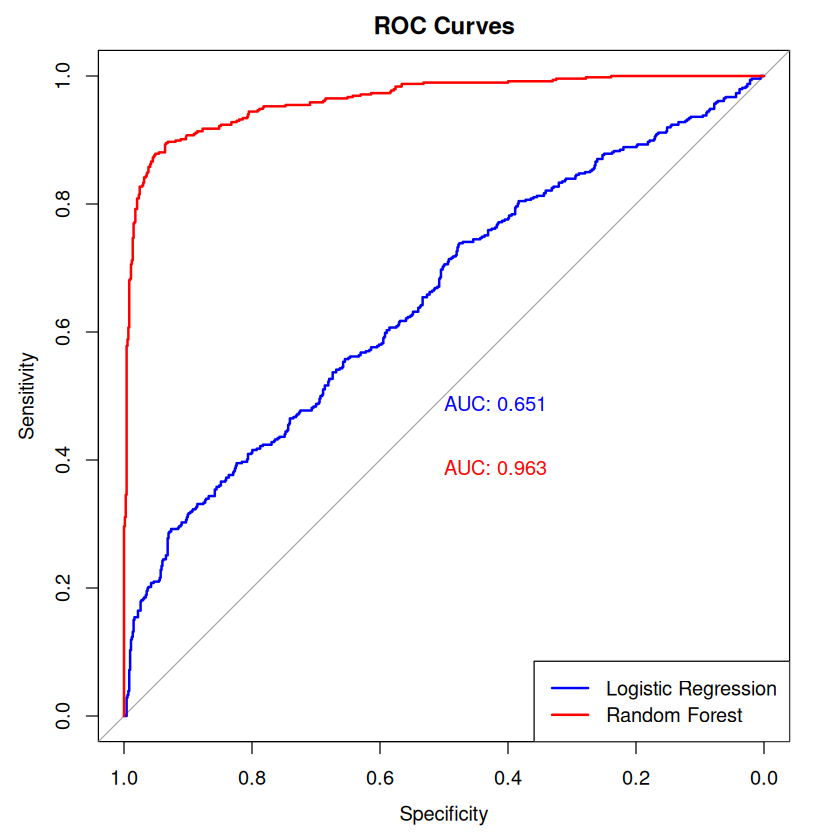

In [7]:
# Load PRROC package for precision-recall curves
library(PRROC)

# Predict on test set
lr_pred <- predict(lr_model, test_data)
rf_pred <- predict(rf_model, test_data)

# Get probabilities for ensemble and PR curves
lr_prob <- predict(lr_model, test_data, type = "prob")[, "Cardiotoxic"]
rf_prob <- predict(rf_model, test_data, type = "prob")[, "Cardiotoxic"]

# Check for NA in predictions and labels
valid_idx <- !is.na(lr_pred) & !is.na(rf_pred) & !is.na(lr_prob) & !is.na(rf_prob) & !is.na(test_data$labels)
if (sum(!valid_idx) > 0) {
  print(paste("Removing", sum(!valid_idx), "rows with NA values in predictions or labels."))
  test_data <- test_data[valid_idx, ]
  lr_pred <- lr_pred[valid_idx]
  rf_pred <- rf_pred[valid_idx]
  lr_prob <- lr_prob[valid_idx]
  rf_prob <- rf_prob[valid_idx]
}

# Weighted ensemble predictions (80% Random Forest, 20% Logistic Regression)
ensemble_prob <- 0.2 * lr_prob + 0.8 * rf_prob
ensemble_pred <- ifelse(ensemble_prob > 0.5, "Cardiotoxic", "Non") %>% factor(levels = c("Non", "Cardiotoxic"))

# Confusion Matrices and F1-score
print("Logistic Regression Confusion Matrix:")
lr_cm <- confusionMatrix(lr_pred, test_data$labels, positive = "Cardiotoxic")
lr_f1 <- 2 * (lr_cm$byClass["Precision"] * lr_cm$byClass["Recall"]) / (lr_cm$byClass["Precision"] + lr_cm$byClass["Recall"])
print(lr_cm)
print(paste("Logistic Regression F1-Score:", round(lr_f1, 4)))

print("Random Forest Confusion Matrix:")
rf_cm <- confusionMatrix(rf_pred, test_data$labels, positive = "Cardiotoxic")
rf_f1 <- 2 * (rf_cm$byClass["Precision"] * rf_cm$byClass["Recall"]) / (rf_cm$byClass["Precision"] + rf_cm$byClass["Recall"])
print(rf_cm)
print(paste("Random Forest F1-Score:", round(rf_f1, 4)))

print("Ensemble Confusion Matrix:")
ensemble_cm <- confusionMatrix(ensemble_pred, test_data$labels, positive = "Cardiotoxic")
ensemble_f1 <- 2 * (ensemble_cm$byClass["Precision"] * ensemble_cm$byClass["Recall"]) / (ensemble_cm$byClass["Precision"] + ensemble_cm$byClass["Recall"])
print(ensemble_cm)
print(paste("Ensemble F1-Score:", round(ensemble_f1, 4)))

# ROC Curves
lr_roc <- roc(test_data$labels, lr_prob, direction = "<", levels = c("Non", "Cardiotoxic"))
rf_roc <- roc(test_data$labels, rf_prob, direction = "<", levels = c("Non", "Cardiotoxic"))

# png("roc_curves.png")
par(bg = "white")
plot(lr_roc, col = "blue", main = "ROC Curves", print.auc = TRUE)
plot(rf_roc, col = "red", add = TRUE, print.auc = TRUE, print.auc.y = 0.4)
legend("bottomright", legend = c("Logistic Regression", "Random Forest"), col = c("blue", "red"), lwd = 2)
# dev.off()

# Precision-Recall Curves
weights_class0 <- as.numeric(test_data$labels == "Cardiotoxic")
if (any(is.na(weights_class0))) {
  print("Warning: NA values in weights_class0. Removing NA entries.")
  valid_pr_idx <- !is.na(weights_class0) & !is.na(lr_prob) & !is.na(rf_prob)
  lr_prob <- lr_prob[valid_pr_idx]
  rf_prob <- rf_prob[valid_pr_idx]
  weights_class0 <- weights_class0[valid_pr_idx]
}

lr_pr <- pr.curve(scores.class0 = lr_prob, weights.class0 = weights_class0)
rf_pr <- pr.curve(scores.class0 = rf_prob, weights.class0 = weights_class0)

print("Logistic Regression PR AUC:")
print(lr_pr$auc.integral)
print("Random Forest PR AUC:")
print(rf_pr$auc.integral)

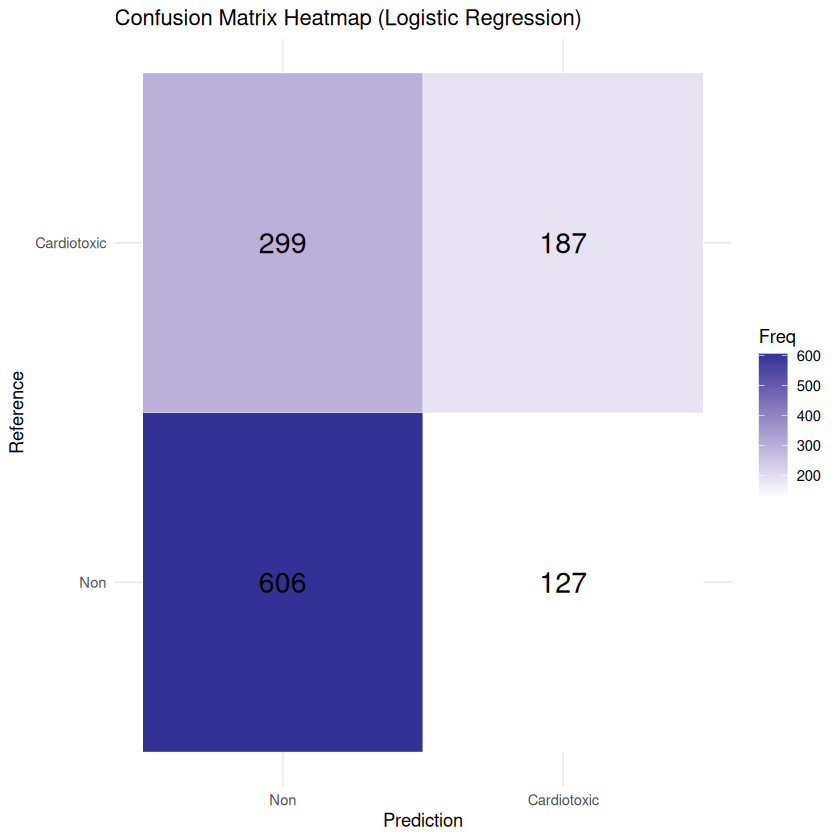

In [8]:
# Convert to data frame
lr_df <- as.data.frame(lr_cm$table)

# Confusion Matrix Heatmap
ggplot(lr_df, aes(x = Prediction, y = Reference, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), size = 6) +
  scale_fill_gradient(low = "white", high = "#323296") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap (Logistic Regression)")

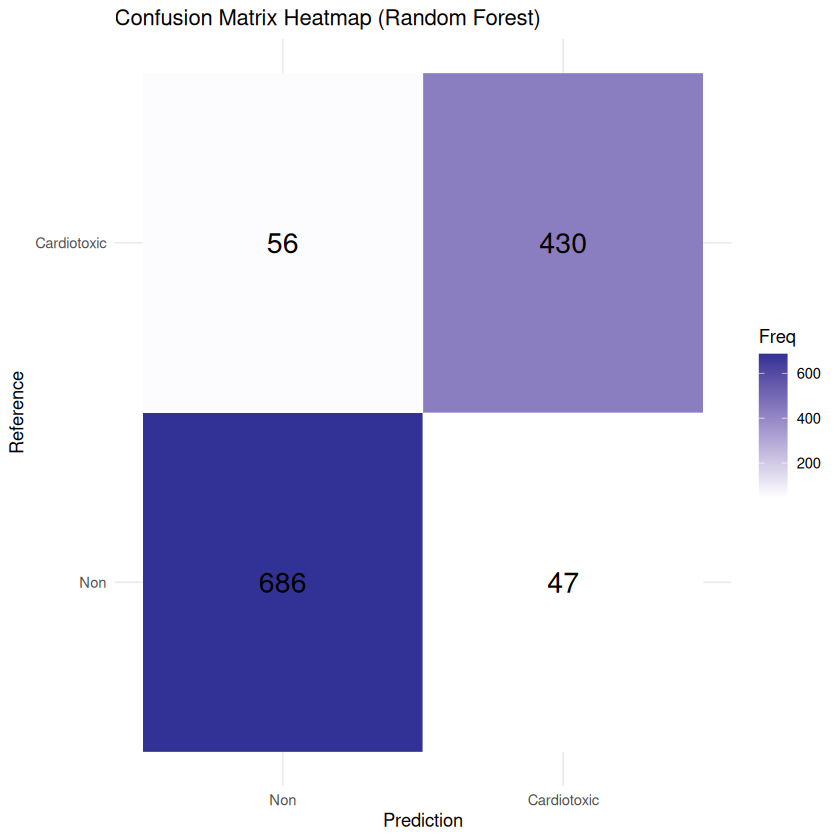

In [9]:
# Convert to data frame
rf_df <- as.data.frame(rf_cm$table)

# Confusion Matrix Heatmap
ggplot(rf_df, aes(x = Prediction, y = Reference, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), size = 6) +
  scale_fill_gradient(low = "white", high = "#323296") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap (Random Forest)")

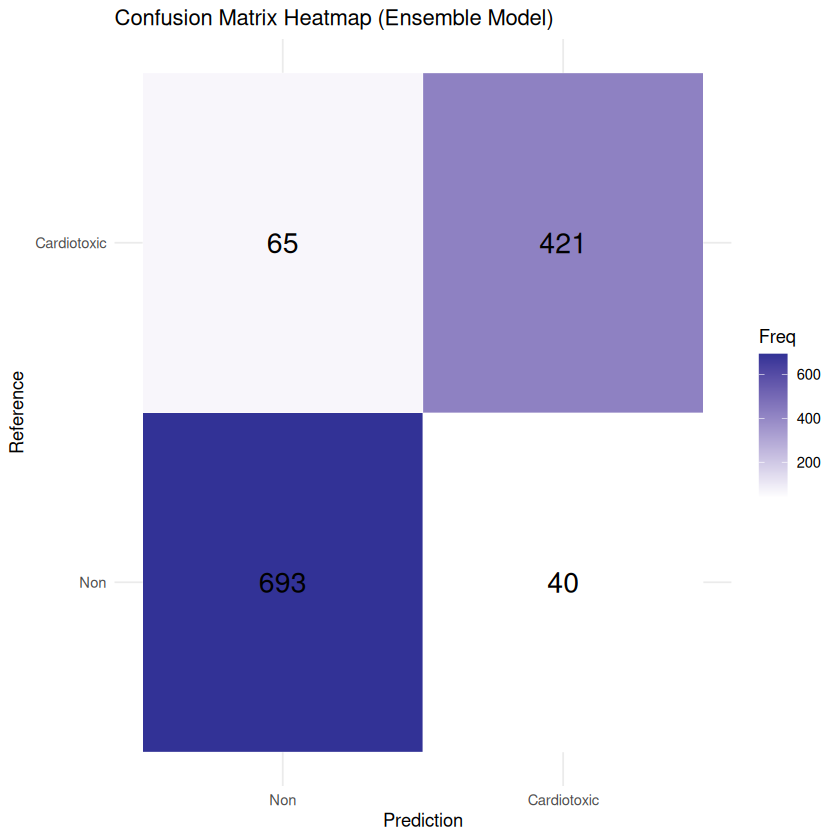

In [10]:
# Convert to data frame
ensemble_df <- as.data.frame(ensemble_cm$table)

# Confusion Matrix Heatmap
ggplot(ensemble_df, aes(x = Prediction, y = Reference, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), size = 6) +
  scale_fill_gradient(low = "white", high = "#323296") +
  theme_minimal() +
  labs(title = "Confusion Matrix Heatmap (Ensemble Model)")

## Step 6: Analyze Coefficients and Feature Importance

We extract Logistic Regression coefficients and Random Forest feature importance to identify key metabolites driving cardiotoxicity predictions.

[1] "Logistic Regression Coefficients:"
6 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)        -0.43514874
`Arachidonic Acid` -0.12782298
Thymidine          -0.37531500
Thymidine.D4        0.09519479
Lactate             0.75861785
`Citrulline-D4`    -0.08794603


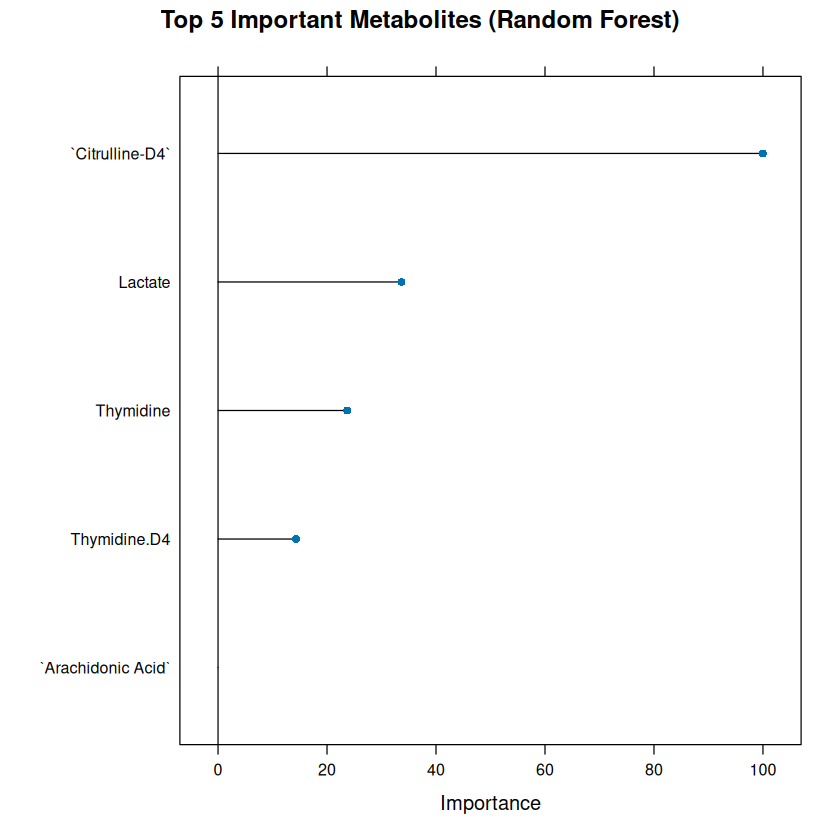

In [11]:
# Logistic Regression coefficients
lr_coefficients <- coef(lr_model$finalModel, s = lr_model$bestTune$lambda)
print("Logistic Regression Coefficients:")
print(lr_coefficients)

# Random Forest feature importance
rf_importance <- varImp(rf_model)
plot(rf_importance, top = 5, main = "Top 5 Important Metabolites (Random Forest)")

## Step 7: Save Models

We save both models for future use or prediction on new data.

In [12]:
# Save models
saveRDS(lr_model, file = "/home/ilesh-dhall/Metabolomics-Biomarker-Discovery/models/logistic_regression_model.rds")
saveRDS(rf_model, file = "/home/ilesh-dhall/Metabolomics-Biomarker-Discovery/models/random_forest_model.rds")
# Example: Predict on new data
# new_data <- read.csv("new_metabolomics_data.csv")
# lr_new_predictions <- predict(lr_model, new_data)
# rf_new_predictions <- predict(rf_model, new_data)